Random forest classifier on Myeloid cells dataset

In [1]:
file_prefix = 'myeloid_' + 'forest_'

In [2]:
%cd /content/drive/My Drive/scanpyfolder
!ls

/content/drive/My Drive/scanpyfolder
B_cells_bayes_heatmap.png	    myeloid_forest_adata.h5ad
B_cells_bayes_predicted_plot.png    myeloidforest_adata.h5ad
B_cells_bayes_test_adata.h5ad	    myeloid_forest_heatmap.png
B_cells_bayes_truth_plot.png	    myeloidforestheatmap.png
B_cells_forest_heatmap.png	    myeloid_forest_predicted_plot.png
bcells_forest.ipynb		    myeloid_forest_test_adata.h5ad
B_cells_forest_predicted_plot.png   myeloidforesttest_adata.h5ad
B_cells_forest_test_adata.h5ad	    myeloid_forest_truth_plot.png
B_cells_forest_truth_plot.png	    myeloidforesttruth_plot.png
B_cells_linear_svc_heatmap.png	    myeloid_linear_svc_heatmap.png
B_cells_linear_svc_test_adata.h5ad  myeloid_linear_svc_predicted_plot.png
B_cells_logreg_heatmap.png	    myeloid_linear_svc_test_adata.h5ad
B_cells_logreg_predicted_plot.png   myeloid_linear_svc_truth_plot.png
B_cells_logreg_test_adata.h5ad	    myeloid_logreg_heatmap.png
B_cells_logreg_truth_plot.png	    myeloid_logreg_predicted_plot.png
B_cells_

In [3]:
!pip install scanpy
!pip install leidenalg
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=4075f61d43678760dedbdf254d391722de631479dba812c8b20efac4958bd0d4
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8027 sha256=a0e968bf1a9fbdff6b87b50ce5b5b3d292eb97707b411686429cb3cb735b023b
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd

In [4]:
import scanpy as sc
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
# Load the .h5ad file
# adata = sc.read('/content/drive/MyDrive/scanpyfolder/datasets/disco_adrenal_gland_v01.h5ad')
# ped_raw_adata = sc.read('/content/drive/MyDrive/scanpyfolder/datasets/pediatric_RAWCOUNTS_cellxgene_c.h5ad')
# ped_fin_adata = sc.read('/content/drive/MyDrive/scanpyfolder/datasets/final_pediatric_object_cellxgene_c.h5ad')

# myeloid raw counts
adata = sc.read('/content/drive/MyDrive/scanpyfolder/datasets/myeloid_raw_counts02_v2.h5ad')

/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
# ped_raw_adata
# ped_fin_adata
adata

AnnData object with n_obs × n_vars = 10988 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'S_score', 'G2M_score', 'phase', 'annotation', 'Gender'
    var: 'gene_ids', 'feature_types'

In [7]:
adata.obs['annotation']

AAGGAGCGTCTGATTG-1-4918STDY7333456    MMP9+ Inflammatory macrophage
AAGGCAGCAGGTGGAT-1-4918STDY7333456                             cDC2
ACGAGGACAGCTCGAC-1-4918STDY7333456                        Mast cell
ACGAGGACAGGCTGAA-1-4918STDY7333456    MMP9+ Inflammatory macrophage
ACGGGTCAGCCTTGAT-1-4918STDY7333456                        Mast cell
                                                  ...              
TGAAAGAAGTGCTGCC-1-WTDAtest7770718                        Monocytes
TGTATTCAGTAAGTAC-1-WTDAtest7770718                        Mast cell
TTCGAAGTCTTACCGC-1-WTDAtest7770718                        Mast cell
TTCTACAAGCGCTCCA-1-WTDAtest7770718                      Macrophages
TCAGCTCCATTCCTGC-1-WTDAtest7770719                        Monocytes
Name: annotation, Length: 10988, dtype: category
Categories (12, object): ['CLC+ Mast cell', 'Lymphoid DC', 'MMP9+ Inflammatory macrophage',
                          'MPO+ mono-neutrophil', ..., 'Monocytes', 'cDC1', 'cDC2', 'pDC']

In [8]:
adata.obs.groupby('annotation').size()

annotation
CLC+ Mast cell                    142
Lymphoid DC                       203
MMP9+ Inflammatory macrophage     333
MPO+ mono-neutrophil              117
Macrophages                      4019
LYVE1+ Macrophages               1771
Mast cell                         432
Megakaryocyte                      59
Monocytes                        1233
cDC1                              431
cDC2                             2029
pDC                               219
dtype: int64

In [9]:
# adata.obs['CLP']

In [10]:
#train

# Extract features (gene expression data) and labels (cell type annotations)
X = adata.X  # gene expressions
y = adata.obs['annotation']  # cell type annotation

In [11]:
# Split the data into train and test sets
# 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

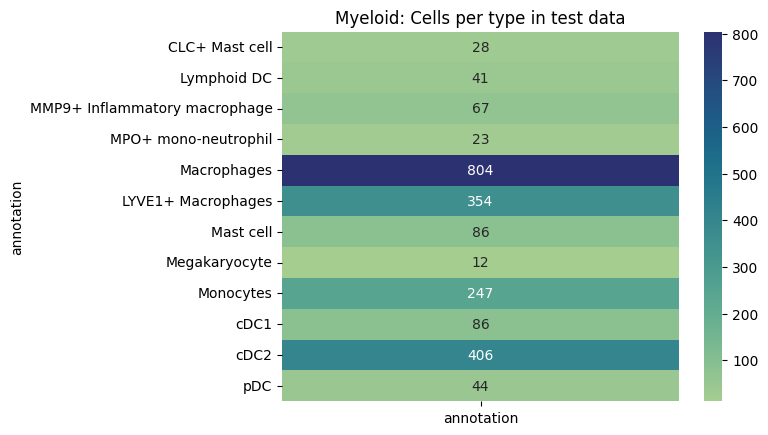

In [38]:
# X_test.shape
# y_test.value_counts()
test_map = sns.heatmap(y_test.groupby(y_test).size().to_frame(), annot=True, fmt='g', cmap="crest")
test_map.set_title('Myeloid: Cells per type in test data')
test_figure = test_map.get_figure().savefig('myeloid_test_map.png', bbox_inches = "tight")

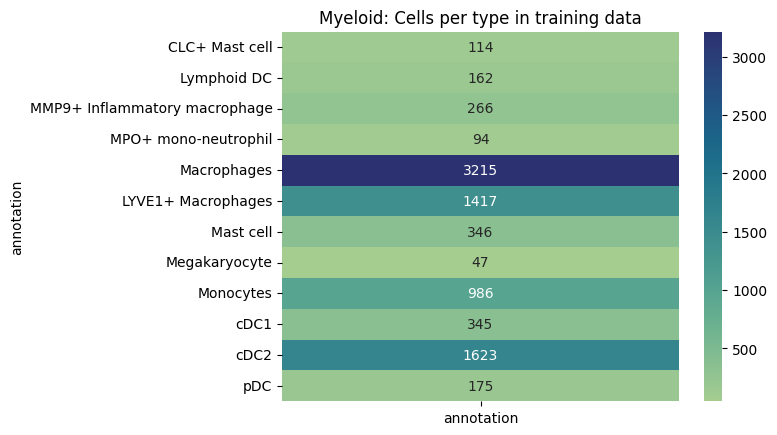

In [39]:
train_map = sns.heatmap(y_train.groupby(y_train).size().to_frame(), annot=True, fmt='g', cmap="crest")
train_map.set_title('Myeloid: Cells per type in training data')
train_figure = train_map.get_figure().savefig('myeloid_train_map.png', bbox_inches = "tight")


In [ ]:
# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [ ]:
# Predict cell types on the test set
y_pred = model.predict(X_test)

In [ ]:
y_pred_series = pd.Series(y_pred, index=y_test.index)
adata.obs['predicted_annotation'] = y_pred_series

In [ ]:
# save adata (with predicted annotations) to a file

# save_adata_file_name =
adata.write(file_prefix + 'test' + '_adata.h5ad')
# !cp save_adata_file_name /content/drive/MyDrive/scanpyfolder/output


In [ ]:
adata.obs['predicted_annotation']

AAGGAGCGTCTGATTG-1-4918STDY7333456                              NaN
AAGGCAGCAGGTGGAT-1-4918STDY7333456                              NaN
ACGAGGACAGCTCGAC-1-4918STDY7333456                              NaN
ACGAGGACAGGCTGAA-1-4918STDY7333456    MMP9+ Inflammatory macrophage
ACGGGTCAGCCTTGAT-1-4918STDY7333456                              NaN
                                                  ...              
TGAAAGAAGTGCTGCC-1-WTDAtest7770718                              NaN
TGTATTCAGTAAGTAC-1-WTDAtest7770718                        Mast cell
TTCGAAGTCTTACCGC-1-WTDAtest7770718                              NaN
TTCTACAAGCGCTCCA-1-WTDAtest7770718                      Macrophages
TCAGCTCCATTCCTGC-1-WTDAtest7770719                              NaN
Name: predicted_annotation, Length: 10988, dtype: category
Categories (12, object): ['CLC+ Mast cell', 'LYVE1+ Macrophages', 'Lymphoid DC',
                          'MMP9+ Inflammatory macrophage', ..., 'Monocytes', 'cDC1', 'cDC2', 'pDC']

In [ ]:
# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
# f1_score = f1_score(y_test,y_pred,average='micro')

print(f'Accuracy: {accuracy}')
# print(f'f1_score: {f1_score}')
print('Classification Report:\n', report)

report = classification_report(y_test, y_pred, output_dict=True)

# Accuracy: 0.7987490071485306
# Classification Report:
#                       precision    recall  f1-score   support

#                 CLP       1.00      0.47      0.63        43
#      Cycling B cell       0.67      0.86      0.75       525
# Cycling plasma cell       0.94      0.10      0.19       291
#          DZ GC cell       0.72      0.57      0.64       230
#     FCRL4+ Memory B       0.00      0.00      0.00        74
#           GC B cell       0.74      0.22      0.34       331
#     IgA plasma cell       0.90      0.99      0.94      4229
#     IgG plasma cell       0.98      0.46      0.63       409
#     IgM plasma cell       1.00      0.04      0.08        72
#          Immature B       0.90      0.49      0.63       200
#          LZ GC cell       0.73      0.34      0.46       141
#            Memory B       0.73      0.86      0.79      1522
#             Naive B       0.65      0.89      0.75      1460
#               Pre-B       0.87      0.62      0.73       109
#               Pro-B       0.95      0.63      0.76       153
#      STAT1+ Naive B       0.91      0.11      0.20       283

#            accuracy                           0.80     10072
#           macro avg       0.79      0.48      0.53     10072
#        weighted avg       0.81      0.80      0.77     10072

Accuracy: 0.8111919927206551
Classification Report:
                                precision    recall  f1-score   support

               CLC+ Mast cell       0.94      0.54      0.68        28
           LYVE1+ Macrophages       0.92      0.87      0.89       354
                  Lymphoid DC       1.00      0.78      0.88        41
MMP9+ Inflammatory macrophage       1.00      0.27      0.42        67
         MPO+ mono-neutrophil       1.00      0.26      0.41        23
                  Macrophages       0.76      0.94      0.84       804
                    Mast cell       0.88      0.99      0.93        86
                Megakaryocyte       1.00      0.92      0.96        12
                    Monocytes       0.88      0.79      0.83       247
                         cDC1       0.98      0.62      0.76        86
                         cDC2       0.72      0.66      0.69       406
                          pDC       1.00      0.84      0.91        44

                     a

Text(0.5, 1.0, 'Random Forest Classifier: Myeloid')

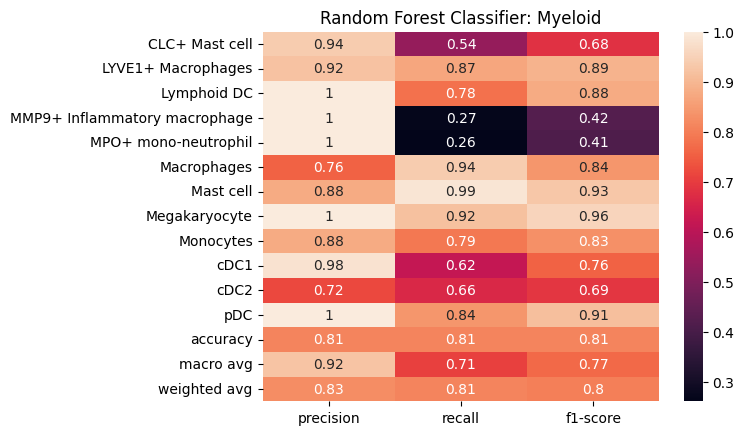

In [ ]:

heatmap = sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
heatmap.set_title('Random Forest Classifier: Myeloid')

In [ ]:
# save the heatmap as a file

heatmap_figure = heatmap.get_figure().savefig(file_prefix + 'heatmap.png', bbox_inches = "tight")
# !cp myeloid_forest_heatmap.png /content/drive/MyDrive/scanpyfolder/output


In [ ]:
adata

AnnData object with n_obs × n_vars = 10988 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'S_score', 'G2M_score', 'phase', 'annotation', 'Gender', 'predicted_annotation'
    var: 'gene_ids', 'feature_types'

In [ ]:
# sc.tl.umap(adata)

In [ ]:
sc.pp.pca(adata, n_comps=30, random_state=0)

In [ ]:
sc.tl.tsne(adata, use_rep='X_pca', random_state=0)

In [ ]:
adata

AnnData object with n_obs × n_vars = 10988 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'S_score', 'G2M_score', 'phase', 'annotation', 'Gender', 'predicted_annotation'
    var: 'gene_ids', 'feature_types'
    uns: 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

In [ ]:
adata.obsm['X_tsne']

array([[-26.647007 , -12.1592045],
       [ 45.346333 , -51.47781  ],
       [-34.052837 , -78.02183  ],
       ...,
       [-17.583942 , -95.28392  ],
       [-28.656874 ,  -8.354455 ],
       [  2.4985995, -53.03769  ]], dtype=float32)

In [ ]:
set(adata.obs['annotation'].cat.categories)==set(adata.obs['predicted_annotation'].cat.categories)

True

In [ ]:
adata.obs['predicted_annotation_']=adata.obs['predicted_annotation'].cat.reorder_categories(adata.obs['annotation'].cat.categories)

In [ ]:
adata.obs['annotation_']=adata.obs['annotation'].copy()
adata.obs['annotation_'][adata.obs['annotation_'].index.isin(
    adata.obs['predicted_annotation_'][adata.obs['predicted_annotation_'].isnull()].index
    )]=np.nan

In [ ]:
adata.obs['predicted_annotation_'][~adata.obs['predicted_annotation_'].isnull()]

ACGAGGACAGGCTGAA-1-4918STDY7333456    MMP9+ Inflammatory macrophage
CATTCGCGTCACTTCC-1-4918STDY7333456                        Mast cell
CCACCTACAGCCAATT-1-4918STDY7333456                      Macrophages
CGCTGGACACTGTCGG-1-4918STDY7333456                      Macrophages
GAACATCGTAGCACGA-1-4918STDY7333456                             cDC2
                                                  ...              
GAGCAGAGTGAGTATA-1-WTDAtest7770718                        Mast cell
GCATGTATCGGATGGA-1-WTDAtest7770718                      Macrophages
TACTTGTCATGTAGTC-1-WTDAtest7770718                        Mast cell
TGTATTCAGTAAGTAC-1-WTDAtest7770718                        Mast cell
TTCTACAAGCGCTCCA-1-WTDAtest7770718                      Macrophages
Name: predicted_annotation_, Length: 2198, dtype: category
Categories (12, object): ['CLC+ Mast cell', 'Lymphoid DC', 'MMP9+ Inflammatory macrophage',
                          'MPO+ mono-neutrophil', ..., 'Monocytes', 'cDC1', 'cDC2', 'pDC']

In [ ]:
(adata.obs['annotation_'].index.isin(
    adata.obs['predicted_annotation_'][~adata.obs['predicted_annotation_'].isnull()].index
    )).sum()

2198

In [ ]:
adata.obs['annotation_'].isnull().sum()

8790

In [ ]:
adata.obs['predicted_annotation_']

AAGGAGCGTCTGATTG-1-4918STDY7333456                              NaN
AAGGCAGCAGGTGGAT-1-4918STDY7333456                              NaN
ACGAGGACAGCTCGAC-1-4918STDY7333456                              NaN
ACGAGGACAGGCTGAA-1-4918STDY7333456    MMP9+ Inflammatory macrophage
ACGGGTCAGCCTTGAT-1-4918STDY7333456                              NaN
                                                  ...              
TGAAAGAAGTGCTGCC-1-WTDAtest7770718                              NaN
TGTATTCAGTAAGTAC-1-WTDAtest7770718                        Mast cell
TTCGAAGTCTTACCGC-1-WTDAtest7770718                              NaN
TTCTACAAGCGCTCCA-1-WTDAtest7770718                      Macrophages
TCAGCTCCATTCCTGC-1-WTDAtest7770719                              NaN
Name: predicted_annotation_, Length: 10988, dtype: category
Categories (12, object): ['CLC+ Mast cell', 'Lymphoid DC', 'MMP9+ Inflammatory macrophage',
                          'MPO+ mono-neutrophil', ..., 'Monocytes', 'cDC1', 'cDC2', 'pDC']

In [ ]:
adata.obs['annotation']

AAGGAGCGTCTGATTG-1-4918STDY7333456    MMP9+ Inflammatory macrophage
AAGGCAGCAGGTGGAT-1-4918STDY7333456                             cDC2
ACGAGGACAGCTCGAC-1-4918STDY7333456                        Mast cell
ACGAGGACAGGCTGAA-1-4918STDY7333456    MMP9+ Inflammatory macrophage
ACGGGTCAGCCTTGAT-1-4918STDY7333456                        Mast cell
                                                  ...              
TGAAAGAAGTGCTGCC-1-WTDAtest7770718                        Monocytes
TGTATTCAGTAAGTAC-1-WTDAtest7770718                        Mast cell
TTCGAAGTCTTACCGC-1-WTDAtest7770718                        Mast cell
TTCTACAAGCGCTCCA-1-WTDAtest7770718                      Macrophages
TCAGCTCCATTCCTGC-1-WTDAtest7770719                        Monocytes
Name: annotation, Length: 10988, dtype: category
Categories (12, object): ['CLC+ Mast cell', 'Lymphoid DC', 'MMP9+ Inflammatory macrophage',
                          'MPO+ mono-neutrophil', ..., 'Monocytes', 'cDC1', 'cDC2', 'pDC']

In [ ]:
adata.obs['predicted_annotation_'].loc[adata.obs['annotation_'].index]

AAGGAGCGTCTGATTG-1-4918STDY7333456                              NaN
AAGGCAGCAGGTGGAT-1-4918STDY7333456                              NaN
ACGAGGACAGCTCGAC-1-4918STDY7333456                              NaN
ACGAGGACAGGCTGAA-1-4918STDY7333456    MMP9+ Inflammatory macrophage
ACGGGTCAGCCTTGAT-1-4918STDY7333456                              NaN
                                                  ...              
TGAAAGAAGTGCTGCC-1-WTDAtest7770718                              NaN
TGTATTCAGTAAGTAC-1-WTDAtest7770718                        Mast cell
TTCGAAGTCTTACCGC-1-WTDAtest7770718                              NaN
TTCTACAAGCGCTCCA-1-WTDAtest7770718                      Macrophages
TCAGCTCCATTCCTGC-1-WTDAtest7770719                              NaN
Name: predicted_annotation_, Length: 10988, dtype: category
Categories (12, object): ['CLC+ Mast cell', 'Lymphoid DC', 'MMP9+ Inflammatory macrophage',
                          'MPO+ mono-neutrophil', ..., 'Monocytes', 'cDC1', 'cDC2', 'pDC']

In [ ]:
adata.obs['predicted_annotation_'].index[adata.obs['predicted_annotation_'].isnull()]

Index(['AAGGAGCGTCTGATTG-1-4918STDY7333456',
       'AAGGCAGCAGGTGGAT-1-4918STDY7333456',
       'ACGAGGACAGCTCGAC-1-4918STDY7333456',
       'ACGGGTCAGCCTTGAT-1-4918STDY7333456',
       'ATAACGCCAGGGATTG-1-4918STDY7333456',
       'ATAAGAGTCCGCGGTA-1-4918STDY7333456',
       'CACACCTGTTAGGGTG-1-4918STDY7333456',
       'CATTATCCAATGTAAG-1-4918STDY7333456',
       'CGAACATGTACCGCTG-1-4918STDY7333456',
       'CGAGCACTCTGCGACG-1-4918STDY7333456',
       ...
       'TCAACGAGTCAAAGAT-1-WTDAtest7770718',
       'TCAATCTCACGTCAGC-1-WTDAtest7770718',
       'TCACAAGTCCAGATCA-1-WTDAtest7770718',
       'TCAGCTCTCGATAGAA-1-WTDAtest7770718',
       'TCAGGTAAGTTCGCGC-1-WTDAtest7770718',
       'TCCACACAGGCAAAGA-1-WTDAtest7770718',
       'TCGCGAGTCAACACCA-1-WTDAtest7770718',
       'TGAAAGAAGTGCTGCC-1-WTDAtest7770718',
       'TTCGAAGTCTTACCGC-1-WTDAtest7770718',
       'TCAGCTCCATTCCTGC-1-WTDAtest7770719'],
      dtype='object', length=8790)

In [ ]:
adata.obs['annotation'].cat.categories

Index(['CLC+ Mast cell', 'Lymphoid DC', 'MMP9+ Inflammatory macrophage',
       'MPO+ mono-neutrophil', 'Macrophages', 'LYVE1+ Macrophages',
       'Mast cell', 'Megakaryocyte', 'Monocytes', 'cDC1', 'cDC2', 'pDC'],
      dtype='object')

In [ ]:
adata.obs['predicted_annotation'].cat.categories

Index(['CLC+ Mast cell', 'LYVE1+ Macrophages', 'Lymphoid DC',
       'MMP9+ Inflammatory macrophage', 'MPO+ mono-neutrophil', 'Macrophages',
       'Mast cell', 'Megakaryocyte', 'Monocytes', 'cDC1', 'cDC2', 'pDC'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


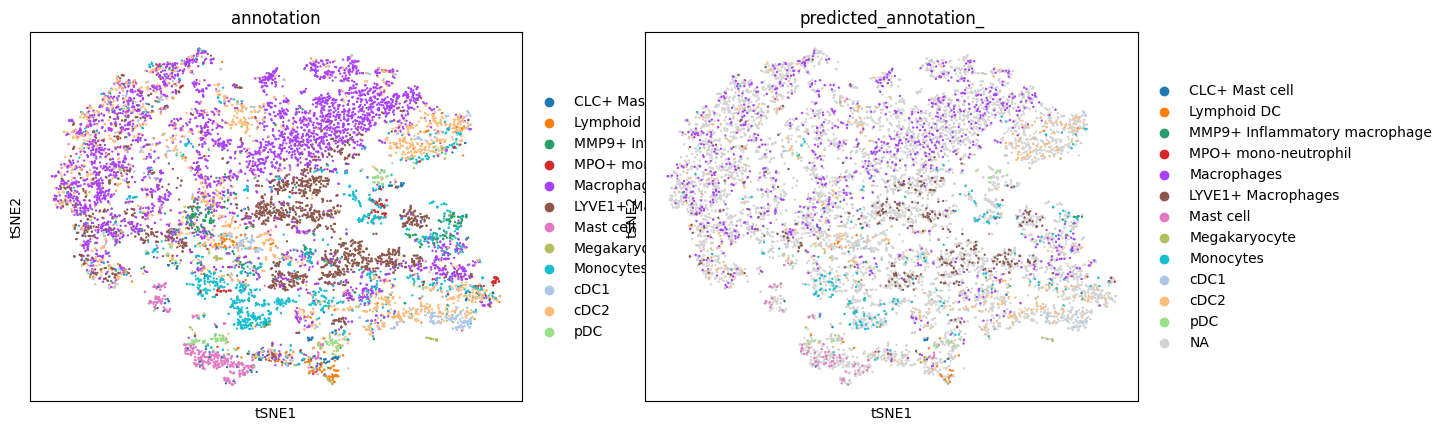

In [ ]:
sc.pl.tsne(adata, color=['annotation', 'predicted_annotation_'])

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


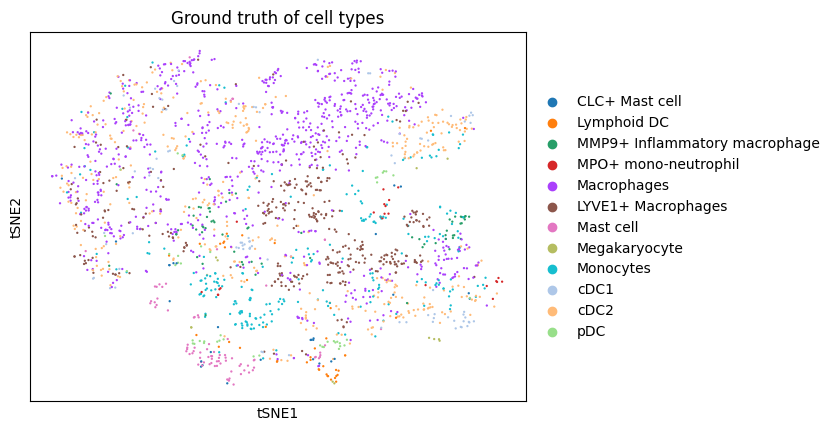

In [ ]:
tsne_truth_plot = sc.pl.tsne(adata, color=['annotation_'], title='Ground truth of cell types', na_in_legend=False, na_color='#00000000', return_fig=True)

In [ ]:
tsne_truth_plot.get_figure().savefig(file_prefix + 'truth_plot.png', bbox_inches = "tight")

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


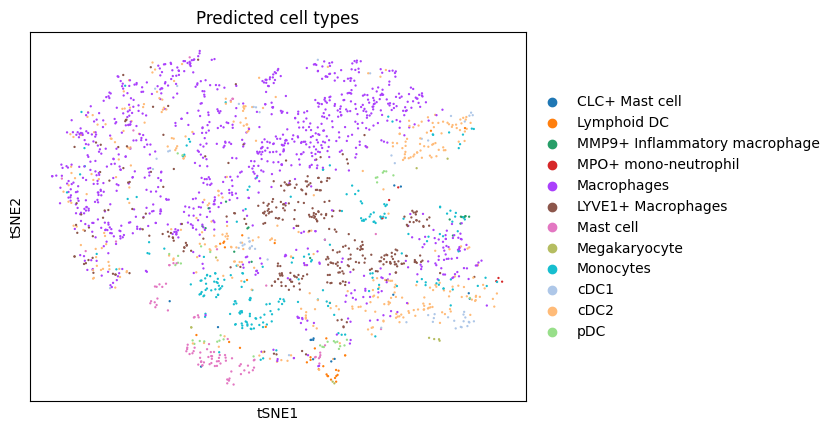

In [ ]:
tsne_predicted_plot = sc.pl.tsne(adata, title='Predicted cell types', color=['predicted_annotation_'], na_in_legend=False, na_color='#00000000', return_fig=True)

In [ ]:
tsne_predicted_plot.get_figure().savefig(file_prefix + 'predicted_plot.png', bbox_inches = "tight")